<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.5: Learning Behaviour Quickly**

### Objective: Investigate a new, simple optimization procedure with clear physiological interpretation.

In this sequence we will:

* Investigate new plasticty rules that are able to aquire adaptive behaviour more rapidly. We continue to work with the strike-no-strike problem where the decision to strike or not is made on the basis of 64 sensory inputs (features) to, and striking is beneficial or costly depending on whether or not prey is actual present.

* Compare these new plasticity rules to perturb-measure-step both in terms of learning rate and physilogical plausibility.

* Understand the efficacy of these new learning rules using an optimization perspective.

* Test these new learning rules on a harder learning problem, still with 64 sensory features, but now with 10 possible behavioural responses to see how increasing the scale of the problem affect the rate at which adaptive behaviour is learned.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this sequence.

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**. It will take a minute. Read ahead while the dependencies are loading.
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
  return

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
#print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S5"

Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.4.1 Learning Strike-No-Strike Quickly with Reward-Prediction-Error and Action-Probability-Reinforcement

Recall from the previous sequence that the cartoon organism that inspires this problem can be thought of as having 64 photo-sensitive receptors, and based on the combination of inputs from these receptors it must decide whether to strike or not. The organism pays a cost of one if it strikes when it shouldn't (prey is absent) and recieves a reward of one if it strikes when it should (prey is present). It receives no cost or reward when it does not strike. To get a sense of this discrimination problem try it yourself by running the code cell below.

In [2]:
# @markdown **Run this cell** to try out the more complex 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y1,
               extra_labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    #sample_order = np.arange(self.features.shape[0])
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    self.extra_labels = extra_labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.current_image = None
    self.previous_image = None
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.prev_fig, self.prev_ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.prev_fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    current_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    previous_feedback = widgets.VBox([self.prev_fig.canvas, self.feedback_display])
    self.ui = widgets.HBox([previous_feedback, current_buttons, self.score_display])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]

    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the first ring to 6 (white)
      image[0, 0] = 6
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    if self.current_image is not None:
      self.previous_image = self.current_image
    image = np.flipud(image)
    self.current_image = image
    # Display the image
    #print(image)
    self.fig.clf()
    self.prev_fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.prev_ax = self.prev_fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.prev_ax.set_xlim(-.5, 7.5)
    self.prev_ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.prev_ax.set_aspect('equal')
    self.ax.axis('off')
    self.prev_ax.axis('off')
    self.ax.imshow(self.current_image, cmap='gray', vmin=-6, vmax=6, origin='upper')
    if self.previous_image is not None:
      self.prev_ax.imshow(self.previous_image, cmap='gray', vmin=-6, vmax=6, origin='upper')
    self.ax.set_title('Current Sensory Input')
    self.prev_ax.set_title('Previous Sensory Input')
    self.fig.canvas.draw()
    self.prev_fig.canvas.draw()

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      #print(self.labels[self.current_index])
      #print(self.extra_labels[self.current_index])
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
display(scramble_bin_hard.prev_fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

We model this creature's sensory-behaviour system as follows. $\mathbf{x}$ is the raw sensory input (column vector) of length 64 in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level of a single photosensitive neuron. We visualize an example sensory input as an $8 \times 8$ grid in the code cell below.

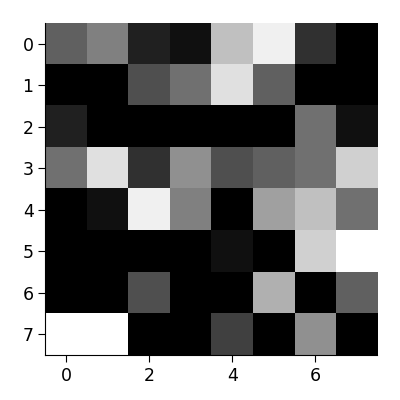

In [3]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level, $z$, of this output neuron is computed as
$$z = \mathbf{Wx} + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron, and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could also be thought of as a row vector.)  

To simplify exposition and coding the input $\mathbf{x}$ is augmented to have a feature which is always 1, and then the bias terms can be treated as the weight connecting to this constant valued feature. That is

$$z = \mathbf{Wx}$$

And now $\mathbf{W}$ has shape 1x65. The probability of striking is determined by the activation level of the output neuron, together with a temperature parameter $\tau$ which determines how exploratory the behaviour of the organism is, specifically:
$$ \Pr \{\text{strike}\} = \sigma(z;\tau) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(z;\tau)$$

Here $$\sigma(z;\tau): \frac{1}{1+\exp(-z / \tau)} = \frac{\exp(z/ \tau)}{1+\exp(z / \tau)}$$ is the logistic (sigmoid) function, with temperature hyper-parameter $\tau$. High values of $\tau$ make striking and not striking have nearly equal probability regardless of the value of $z$, whereas very low values of $\tau$ mean that even a very slightly positive $z$ value will correspond to near certainty of striking, and a very slight negative value will result in an almost certain chance of not striking. In other words $\tau$ determines how responsive the striking probabilities are to changes in $z$.

Instead of thinking of $z$ as simply just a way of determining the striking probability, we could also treat $z$ as a kind of prediction or expectation of the reward that will occur if the striking action is taken given the current sensory experience $\mathbf{x}$. As the expectation of reward recieved increases, the probability of taking the striking action also increases, if the expectation of reward recieved the probability of taking the striking action decreases, according the the temperature scaled softmax function above.

Taking this perspective, where $z$ as the organism's internal representation of the expected reward when taking the striking action, then the organism could compare its expectation of reward with the reward it actually receives, and use the difference between expectation and reality to update the synaptic weights that had a causal impact on this expectation in such a way that the expected reward more closely aligns with the received reward. Given our current network model of the sensory-behaviour system a rule that does this is:

## Reward-Prediction-Error Episodic Update Rule

$$\Delta W_i = s \cdot (r-z) \cdot x_i $$

Or in vector form

$$ \Delta \mathbf{W} = s \cdot (r-z) \cdot \mathbf{x}^T$$


This is saying that if the received reward is greater than the predicted reward, then it would be better if $z$ had been larger, which means that in the cases where $x_i$ was positive, the weight from $x_i$ should be increased, in proportion to the strength of activation of $x_i$ and in the case that $x_i$ was negative, the weight from $x_i$ should be decreased, again in proportion to the strength of the activation of $x_i$. Conversely if, the reward received is less than predicted then it would have been better if $z$ was smaller and so, in the case where $x_i$ is positive the weight from $x_i$ should be decreased, in proportion to the strength of the activation of $x_i$ and in the case that $x_i$ is negative, the weight from $x_i$ should be decreased. (Note that in the vector formulation above we $\mathbf{x}^T$ since $\mathbf{x}$ is column vector (65, 1) whereas $\mathbf{W}$ is a row vector (1, 65), and the shape and orientation of $\Delta \mathbf{W}$ should match the shape of $\mathbf{W}$.)

This rule can be understood as shifting the weights $\mathbf{W}$ in the direction that minimizes the squared error of the reward prediction.

$$ z = \mathbf{W}\mathbf{x}$$
$$\begin{align} \nabla_\mathbf{W} (r-z)^2 & = 2 \ (r-z) \ \nabla_{\mathbf{W}}z \\
& = 2 (r-z) \mathbf{x}^T
\end{align}$$
The factor of 2 is subsumed in the step scaling factor $s$.

We call this an episodic update rule because it can concievably be implemented after a single experience of sensory input, action selection, and resultant reward.

In this scenario the prediction pertains to the reward when striking, so this difference between expected and received reward simply does not apply to the case where no striking occurs, so no learning occurs without striking. Note that the $\tau$ parameter in the sigmoid striking probability function determines how exploratory the behaviour is independently of the predicted reward. $\tau$ is very important. During the earlier episodes of the organism's life it should be more exploratory (higher $\tau$), but once it has learned good predictions of reward across a representative range of experiences it can settle into simply exploiting the knowledge it has acquired (lower $\tau$). Deciding when and how to transition from exploratory behaviours to more directly reward maximizing behaviours is known as an exploration-exploitation trade-off, and is a central challenge in Reinforcement Learning. We just mention this in passing now, but will dive more deeply into the exploration-exploitation tradeoff in sequence (blah).

There is also a "cheating" version of this update rule, where an update to the parameters is always made based on the $r_{\text{strike}}$, the reward that the organism would recieve if it strikes, regardless of whether it actually strikes or not, i.e. it gets to know what the right answer was regardless of what action it takes. This could be implemented by the organism having some additional, post-hoc prey detection that augments the organism's basic behavioural inputs with additional teaching signals. These additional signals allow the organism to learn from situations where it's like "Oh I wish I had struck at the food that is now swimming past me" and also situations where it's like "Oh there really was no food there, good thing I didn't strike". Such mechanism likely exist, but are more complex than the simple case of reinforcing actions taken based on intrinsic reward recieved. Our focus for now is this simple case. (We could approximate such a system by "rewarding" not striking when no prey is present with 1 and giving a penalty of 1 when an organism fails to strike when prey is present, but this leaves open the question of if and how such "learning scaffolding" rewards need to be and can be kept seperate from 'actual' rewards that count towards fitness in the evolutionary sense. This is a complex topic that we will revist throught the book, in particular in sequences (blah)).

From an evolutionary and adaptive behaviour perspective we are interested in how the organism can quickly learn to take rewarding actions. This suggest an alternative updating scheme where the reward recieved directly reinforces the probability of taking the action that produced it. To do this we need know how a change in $z$ translates into an increase (or decrease) in the probability of striking, so that we can increase (decrease) action probabilites in proportion to the rewards recieved as a result of particular action choices. We call this the Action-Probability-Reinforcement update rule

## Action Probability Reinforcement Episodic Update Rule

$$ \Delta W_i = s \cdot r \cdot \sigma'(z) \cdot x_i$$

or in vector form

$$ \Delta \mathbf{W} = s \cdot r \cdot \sigma'(z) \cdot \mathbf{x}$$

Here $\sigma'$ is the derivative of the sigmoid striking probability function. We no longer need to explicitly control exploration versus exploitation with $\tau$, since this update rule acts directly on action probabilities, so we simply set $\tau =1$ here for simplicity. The above rule uses the raw rewards to reinforce actions. The probability of striking is given by $\sigma(z)$ so the way to change $\mathbf{W}$ to increase the probability of striking is to shift the weights in the direction of the gradient of the probability of taking the action given by $\sigma'(z)$. Using the defination of $\sigma$ above and the chain rule from calculus we can derive that $\sigma'(z) = \sigma(z) (1-\sigma(z))$. This is telling us what we already know intuitively about the sigmoid function, which is that it is montonically increasing, and relatively flat when probalities are close to zero or one, and steepest when probabilities are close to even, that is 0.5.

The above rule can be understood as shifting weights $\mathbf{W}$ so that the probability of striking in a particular instance ($\mathbf{x}$) is increased (or decreased in the case of negative reward) in proportion to the rewards that result from taking the striking action.
$$ \Pr\{\text{strike}|\mathbf{x}\} = \sigma(\mathbf{W}\mathbf{x})$$
$$\begin{align} \Delta \mathbf{W} &= s \cdot \nabla_\mathbf{W} \Pr\{\text{strike}| \mathbf{x}\} \cdot r \\
& = s \cdot \sigma'(z) \cdot \nabla_{\mathbf{W}} \mathbf{Wx} \cdot r \\
& = s \cdot \sigma'(z) \cdot \mathbf{x} \cdot r \\
& = s \cdot \sigma(z) (1 - \sigma(z)) \cdot \mathbf{x} \cdot r
\end{align}$$

Again we call this an episodic update rule because it can concievably be applied after a single episode consisting of sensory experience, action selection, and resultant reward.

Again, this rule also has a cheating variant. The normal variant exclusively uses the actual reward $r$ obtained from sampling an action, and experiencing the subsequent reward. In contrast, the cheating variant (often used in ML contexts) uses the expected reward $\mathbb{E}[r]$ given the probability distribution over possible actions instead of utilizing a particular sample from the distribution of possible actions and the particular resultant reward. From a practical ML perspective it is sometimes much more efficient to directly compute expected rewards than to sample actions and rewards stochastically, and in these cases using expectations can greatly accelerate learning. However, this cheating variant is only episodic if it is able to somehow consider all possible actions and all possible outcomes within that single episode, certainly possible, but adds the complexity of trying to learn from hypothetical outcomes, much as in the cheating version of Reward-Prediction-Error update rule.




Complete the coding exercise below to see how these two different udpated rules, reward-prediction-error and action-probability-reinforcement, compare with our perturb-measure-step rule, both when using "realistic" episodic and cheating variants. Note the that the `eval_params` function we use below can be thought of as containing both an action selection component that depends on the sensory inputs $\mathbf{x}$ and the parameters $\mathbf{W}$ and then a reward component that calculates the appropriate reward given the action selected and the true state of the environment encoded in $y$, i.e. the presense or absence of prey which is as yet unobserved by organisms.

In [4]:
################################################################################
# TODO for students: Replace ... in the lines below with one of the following
# options, each option get's used exactly once
# a) r * (strike_prob) * (1 - strike_prob) * x
# b) (r_all - z) * x
# c) (np.mean(r_perturb - r)) / perturbation_scale
# d) r_exp * (strike_prob) * (1 -  strike_prob) * x
# e) (np.mean(r_exp_perturb - r_exp)) / perturbation_scale
# f) (r-z) * strike * x
# This will implement different update rules driven by: Reward Prediction Error,
# Reinforcement of Action ProbabilitiesTrue Positives, or Peturb-Measure
# estimate of the gradient of expected reward. Both in a strict, experience
# driven way, and in "cheating" a bit way.
raise NotImplementedError("Exercise: Implement different update rules to compare")
################################################################################

def np_sigmoid(x, tau=1):
  # high tau more exploration, low tau very little exploration
  x_scaled = np.clip(x/tau, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x/tau))

def eval_params(W, x, y, tau=1, rng=None):
  """
  Parameters:
  - W (ndarray, shape: (1, n_inputs)): Connective strength weights between inputs and the output.
  - x (ndarray, shape: (n_inputs, batch)): Input features, col is a sample, each row an input feature type.
  - y (ndarray, shape: (1, batch)): Binary indication of prey presence, used to determine the reward.
  - tau (float, optional): Temperature parameter for the sigmoid function, controlling its steepness.
    A higher tau value leads to a steeper function.
  - rng (np.random.Generator, optional): NumPy random number generator instance for reproducibility.
  """
  if rng is None:
    rng = np.random.default_rng()
  z = np.dot(W, x) # 1 x batch = 1 x n_inputs @ n_inputs x batch
  strike_prob = np_sigmoid(z, tau) # 1 x batch
  strike = np.array(rng.random(size=strike_prob.shape) < strike_prob, int) # 1->did, 0->didn't
  r = np.where(y == 1, strike, -strike) # sampled reward
  r_all = 2*y-1 # reward when striking in all cases
  r_exp = strike_prob * r_all # + (1-strike_prob) * 0 # expected reward
  return z, strike_prob, strike, r, r_all, r_exp

def reward_prediction_step(W, x, y,
                           cheat=False,
                           tau=1.0,
                           rng=None,
                           learning_rate=0.0001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn regardless of whether organism actually strikes or not
    update = ...
  else: # properly episodic
    # learn only from actual recieved rewards
    update = ...
  # average the update over all elements in the batch
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def action_prob_step(W, x, y,
                     cheat=False,
                     tau=1,
                     rng=None,
                     learning_rate=0.001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn using expected reward
    update = ...
  else: # properly episodic
    # learn only from actual recieved rewards
    # reward of zero recieved when not striking
    update = ...
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def perturb_measure_step(W, x, y,
                         perturbation_scale=0.01,
                         cheat=False,
                         tau=1,
                         rng=None,
                         learning_rate=0.001):
  if rng is None:
    rng = np.random.default_rng()
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  raw_test_perturb = learn_rng.standard_normal(size=(W.shape))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  perturbed_W = W + test_perturbation
  _, _, _, r_perturb, r_all_perturb, r_exp_perturb = eval_params(perturbed_W, x, y, tau, rng)
  if cheat:
    # evaluate perturbation using expected reward, avg over the mini-batch
    directional_grad_est = ...
  else: # more episodic (still evaluate peturb and base on same experiences)
    # evaluate perturbation using sampled rewards, avg over the mini-batch
    directional_grad_est = ...
  update = learning_rate * directional_grad_est * unit_test_perturb
  W_new = W + update
  return W_new, r, r_exp

################################################################################
# Exercise Complete, simulations and plotting logic follow
################################################################################
# simulation
learn_rng = np.random.default_rng(0)
num_epochs = 1
num_steps = 0
mini_batch_size = 1
cooling_rate = 0.04
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_step, action_prob_step, perturb_measure_step]
# cheating simulation
cheat_alg_lrs = {'Reward Prediction': 0.0001,
                 'Action Probability': 0.008,
                 'Perturb Measure': 0.0016}
cheat_reward_results = {alg_name: [] for alg_name in alg_names}
cheat_exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = cheat_alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=True, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      cheat_reward_results[alg_name].append(np.mean(r))
      cheat_exp_reward_results[alg_name].append(np.mean(r_exp_full))
    num_steps += 1
    if num_steps > 1000:
      break

num_steps = 0
real_alg_lrs = {'Reward Prediction': 0.0001,
                'Action Probability': 0.003,
                'Perturb Measure': 0.0000002}
# realishtic simulation
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
actual_reward_results = {alg_name: [] for alg_name in alg_names}
actual_exp_reward_results = {alg_name: [] for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = real_alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      actual_reward_results[alg_name].append(np.mean(r))
      actual_exp_reward_results[alg_name].append(np.mean(r_exp_full))
    num_steps += 1
    if num_steps > 1000:
      break
# plotting
with plt.xkcd():
  # Create subplots with a shared x-axis
  #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
  fig, ax1 = plt.subplots(figsize=(8,6))
  theoretical_max = np.sum(y1 == 1) / len(y1)

  # Colors for algorithms
  colors = {'Reward Prediction': 'b', 'Action Probability': 'g', 'Perturb Measure': 'r'}

  # First subplot for expected rewards
  ax1.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval_cheat = np.array(cheat_exp_reward_results[alg_name])
    eval_cheat = np.cumsum(eval_cheat)
    eval_cheat = eval_cheat / (np.arange(len(eval_cheat)) + 1)
    ax1.plot(eval_cheat, linestyle='--', color=colors[alg_name], label=f'{alg_name}-Cheating')

    eval_real = np.array(actual_exp_reward_results[alg_name])
    eval_real = np.cumsum(eval_real)
    eval_real = eval_real / (np.arange(len(eval_real)) + 1)
    ax1.plot(eval_real, linestyle='-', color=colors[alg_name], label=f'{alg_name}')

  ax1.set_title('Cumulative per Episode Average of\nExpected (Full Batch) Reward')
  ax1.set_ylabel('Cumulative Avg. Expected Reward')
  ax1.legend()
  # Second subplot for actual rewards
  # ax2.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  # for alg_name in alg_names:
  #  eval_cheat = np.array(cheat_reward_results[alg_name])
  #  eval_cheat = np.cumsum(eval_cheat)
  #  eval_cheat = eval_cheat / (np.arange(len(eval_cheat)) + 1)
  #  ax2.plot(eval_cheat, linestyle='--', color=colors[alg_name], label=f'{alg_name}-Cheating')

  #  eval_real = np.array(actual_reward_results[alg_name])
  #  eval_real = np.cumsum(eval_real)
  #  eval_real = eval_real / (np.arange(len(eval_real)) + 1)
  #  ax2.plot(eval_real, linestyle='-', color=colors[alg_name], label=f'{alg_name}-Realishtic')

  #ax2.set_title('Cumulative Average of Actual Reward Per Learning Episode')
  #ax2.set_xlabel('Learning Episodes')
  #ax2.set_ylabel('Cumulative Avg. Actual Reward')
  #ax2.legend()
  plt.tight_layout()
  plt.show()

NotImplementedError: Exercise: Implement different update rules to compare

<ipython-input-5-c93c4c03129c>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x/tau))


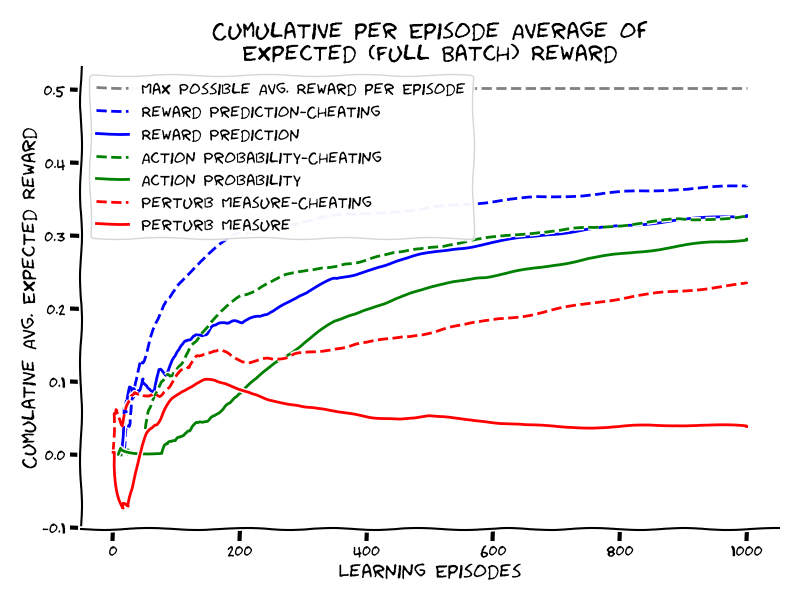

/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.manager.handle_json(content)


In [5]:
# to_remove solution

def np_sigmoid(x, tau=1):
  # high tau more exploration, low tau very little exploration
  x_scaled = np.clip(x/tau, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x/tau))

def eval_params(W, x, y, tau=1, rng=None):
  """
  Parameters:
  - W (ndarray, shape: (1, n_inputs)): Connective strength weights between inputs and the output.
  - x (ndarray, shape: (n_inputs, batch)): Input features, col is a sample, each row an input feature type.
  - y (ndarray, shape: (1, batch)): Binary indication of prey presence, used to determine the reward.
  - tau (float, optional): Temperature parameter for the sigmoid function, controlling its steepness.
    A higher tau value leads to a steeper function.
  - rng (np.random.Generator, optional): NumPy random number generator instance for reproducibility.
  """
  if rng is None:
    rng = np.random.default_rng()
  z = np.dot(W, x) # 1 x batch = 1 x n_inputs @ n_inputs x batch
  strike_prob = np_sigmoid(z, tau) # 1 x batch
  strike = np.array(rng.random(size=strike_prob.shape) < strike_prob, int) # 1->did, 0->didn't
  r = np.where(y == 1, strike, -strike) # sampled reward
  r_all = 2*y-1 # reward when striking in all cases
  r_exp = strike_prob * r_all # + (1-strike_prob) * 0 # expected reward
  return z, strike_prob, strike, r, r_all, r_exp

def reward_prediction_step(W, x, y,
                           cheat=False,
                           tau=1.0,
                           rng=None,
                           learning_rate=0.0001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn regardless of whether organism actually strikes or not
    update = (r_all - z) * x
  else: # properly episodic
    # learn only from actual recieved rewards
    update = (r-z) * strike * x
  # average the update over all elements in the batch
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def action_prob_step(W, x, y,
                     cheat=False,
                     tau=1,
                     rng=None,
                     learning_rate=0.001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn using expected reward
    update = r_exp * (strike_prob) * (1 -  strike_prob) * x
  else: # properly episodic
    # learn only from actual recieved rewards
    # reward of zero recieved when not striking
    update = r * (strike_prob) * (1 - strike_prob) * x
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def perturb_measure_step(W, x, y,
                         perturbation_scale=0.01,
                         cheat=False,
                         tau=1,
                         rng=None,
                         learning_rate=0.001):
  if rng is None:
    rng = np.random.default_rng()
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  raw_test_perturb = learn_rng.standard_normal(size=(W.shape))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  perturbed_W = W + test_perturbation
  _, _, _, r_perturb, r_all_perturb, r_exp_perturb = eval_params(perturbed_W, x, y, tau, rng)
  if cheat:
    # evaluate perturbation using expected reward, avg over the mini-batch
    directional_grad_est = (np.mean(r_exp_perturb - r_exp)) / perturbation_scale
  else: # more episodic (still evaluate peturb and base on same experiences)
    # evaluate perturbation using sampled rewards, avg over the mini-batch
    directional_grad_est = (np.mean(r_perturb - r)) / perturbation_scale
  update = learning_rate * directional_grad_est * unit_test_perturb
  W_new = W + update
  return W_new, r, r_exp

################################################################################
# Exercise Complete, simulations and plotting logic follow
################################################################################
# simulation
learn_rng = np.random.default_rng(0)
num_epochs = 1
num_steps = 0
mini_batch_size = 1
cooling_rate = 0.04
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_step, action_prob_step, perturb_measure_step]
# cheating simulation
cheat_alg_lrs = {'Reward Prediction': 0.0001,
                 'Action Probability': 0.008,
                 'Perturb Measure': 0.0016}
cheat_reward_results = {alg_name: [] for alg_name in alg_names}
cheat_exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = cheat_alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=True, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      cheat_reward_results[alg_name].append(np.mean(r))
      cheat_exp_reward_results[alg_name].append(np.mean(r_exp_full))
    num_steps += 1
    if num_steps > 1000:
      break

num_steps = 0
real_alg_lrs = {'Reward Prediction': 0.0001,
                'Action Probability': 0.003,
                'Perturb Measure': 0.0000002}
# realishtic simulation
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
actual_reward_results = {alg_name: [] for alg_name in alg_names}
actual_exp_reward_results = {alg_name: [] for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = real_alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      actual_reward_results[alg_name].append(np.mean(r))
      actual_exp_reward_results[alg_name].append(np.mean(r_exp_full))
    num_steps += 1
    if num_steps > 1000:
      break
# plotting
with plt.xkcd():
  # Create subplots with a shared x-axis
  #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
  fig, ax1 = plt.subplots(figsize=(8,6))
  theoretical_max = np.sum(y1 == 1) / len(y1)

  # Colors for algorithms
  colors = {'Reward Prediction': 'b', 'Action Probability': 'g', 'Perturb Measure': 'r'}

  # First subplot for expected rewards
  ax1.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval_cheat = np.array(cheat_exp_reward_results[alg_name])
    eval_cheat = np.cumsum(eval_cheat)
    eval_cheat = eval_cheat / (np.arange(len(eval_cheat)) + 1)
    ax1.plot(eval_cheat, linestyle='--', color=colors[alg_name], label=f'{alg_name}-Cheating')

    eval_real = np.array(actual_exp_reward_results[alg_name])
    eval_real = np.cumsum(eval_real)
    eval_real = eval_real / (np.arange(len(eval_real)) + 1)
    ax1.plot(eval_real, linestyle='-', color=colors[alg_name], label=f'{alg_name}')

  ax1.set_title('Cumulative per Episode Average of\nExpected (Full Batch) Reward')
  ax1.set_ylabel('Cumulative Avg. Expected Reward')
  ax1.set_xlabel('Learning Episodes')
  ax1.legend()
  # Second subplot for actual rewards
  # ax2.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  # for alg_name in alg_names:
  #  eval_cheat = np.array(cheat_reward_results[alg_name])
  #  eval_cheat = np.cumsum(eval_cheat)
  #  eval_cheat = eval_cheat / (np.arange(len(eval_cheat)) + 1)
  #  ax2.plot(eval_cheat, linestyle='--', color=colors[alg_name], label=f'{alg_name}-Cheating')

  #  eval_real = np.array(actual_reward_results[alg_name])
  #  eval_real = np.cumsum(eval_real)
  #  eval_real = eval_real / (np.arange(len(eval_real)) + 1)
  #  ax2.plot(eval_real, linestyle='-', color=colors[alg_name], label=f'{alg_name}-Realishtic')

  #ax2.set_title('Cumulative Average of Actual Reward Per Learning Episode')
  #ax2.set_xlabel('Learning Episodes')
  #ax2.set_ylabel('Cumulative Avg. Actual Reward')
  #ax2.legend()
  plt.tight_layout()
  plt.show()

Looking at the plots produced by the coding exercise we can see that Reward-Prediction-Error and Action-Probability-Reinforcement both learn to (fairly) effectively discriminate between when prey is and is not present much more quickly, i.e. with fewer learning episodes, than Perturb-Measure-Step. And, this difference in number of learning episodes required to learn "good" behaviour is much greater for the episodic variants than for the cheating variants.




Although all the learning algorithms learn less quickly when not allowed to cheat, Perturb-Measure-Step suffers the most.

Let's take a moment to think about how the Episodic vs. Cheating variants differ for each of these update rules.
* **reward-prediction-error**: In episodic mode can only learn when it strikes and there is an actual reward recieved (plus or minus one, to contrast with the prediction). When cheating always learns as though it had made a strike;
* **action-probability-reinforcement**: In episodic mode only reinforces the actual action taken by the reward recieved.  When cheating all actions are reinforced by expected reward in proportion to the probability of having taken that action/
* **perturb-measure-step**: In episodic compares an actual reward recieved under the base evaluation mode against the actual reward recieved under the perturbation mode to evaluate the perturbation. When cheating this evaluation is made using expected reward, not sampled reward.

Why does this cause such a big slow down for perturb-measure-step? When learning from a single experience, and using actual sampled rewards, very few outcomes actually result in effective learning for perturb-measure-step, as can be seen in the table below:

| Case | Correct<br>Action | Perturb<br>Action | Base<br>Action | Perturb - Base<br>Reward<br>Difference | Learning<br>Happens | P(Strike, Perturb)<br> greater than<br>P(Strike, Base) | Learning is<br>Helpful |
|:-------------:|:-------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|
|1 | Strike    | Strike    | Strike    | 0  | No  | - | | -   |
|2 | Strike    | Strike    | No-Strike | 1  | Yes | Yes | Yes |
|3 | Strike    | Strike    | No-Strike | 1  | Yes | No  | No  |
|4 | Strike    | No-Strike | Strike    | -1 | Yes | Yes | No  |
|5 | Strike    | No-Strike | Strike    | -1 | Yes | No  | Yes |
|6 | Strike    | No-Strike | No-Strike | 0  | No  | -   | -   |
|7 | No-Strike | Strike    | Strike    | 0  | No  | -   | -   |
|8 | No-Strike | Strike    | No-Strike | -1 | Yes | Yes | Yes |
|9 | No-Strike | Strike    | No-Strike | -1 | Yes | No  | No  |
|10| No-Strike | No-Strike | Strike    | 1  | Yes | Yes | No  |
|11| No-Strike | No-Strike | Strike    | 1  | Yes | No  | Yes |
|12| No-Strike | No-Strike | No-Strike | 0  | No  | -   | -   |

This is a bit dense, but what it is saying is that first of all, there are many cases where no learning occurs because both the pertubation and the base mode sample the same action and recieve the same rewards, so there is no reward difference at all to drive learning. Note that for small perturbations the action probabilities of the base and perturbed networks will be very similar, so these no learning cases will be the most commen case by far as perturbation sizes become increasinly small. Then, even in the cases where the perturbation mode and the base mode do sample different actions, it is possible that the sampled actions will run counter to the way the perturbation have shifted the probability of striking. Case 3 in the table above is an example of this. Under the perturbation the probability of striking is not greater than (but rather less than) the probability of striking with the base parameters, however, despite this, the less likely outcome where the perturb network samples striking, and the base network samples not-striking occurs. Because the sample is not aligned with the underlying shift in probabilities caused by the perturbation, learning from this difference is counterproductive. Now on average, learning will help shift probabilities towards striking in the right situations. However, it will do so only slowly, as many learning episodes will result in no learning, or counterproductive learning.


In [6]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.4.2 Perturb-Measure-Step is Slow Because of Poor Gradient Alignment
Although Perturb-Measure-Step suffered the most from using strictly episodic learning, even when learning on the full batch instead of just one example at a time, and using expected rewards, we still see that perturb-measure-step is slow compared to reward-prediction-error and action-probability-reinforcement.

<ipython-input-5-c93c4c03129c>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x/tau))


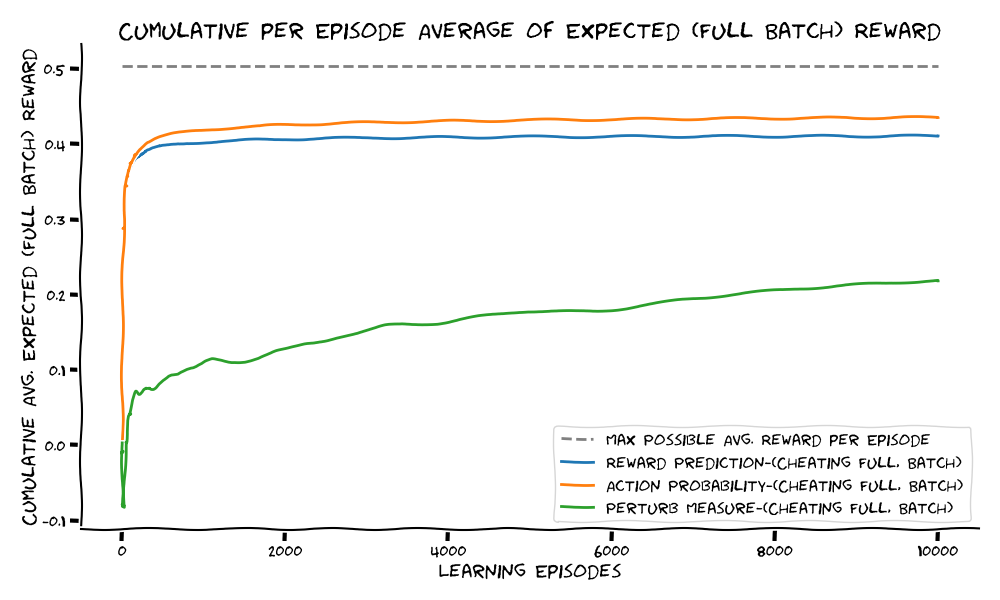

In [7]:
# @markdown **Run this cell** - to see how perturb-measure-step is slow relative to reward-prediction-error and action-probability-reinforcement, even when using full-batch learning and expected rewards.
learn_rng = np.random.default_rng(0)
num_epochs = 10000
num_steps = 0
mini_batch_size = Xs_aug.T.shape[0]
cooling_rate = 0.04
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_step, action_prob_step, perturb_measure_step]
alg_lrs = {'Reward Prediction': 0.0015,
                 'Action Probability': 0.08,
                 'Perturb Measure': 0.001}
actual_reward_results = {alg_name: [] for alg_name in alg_names}
exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      r = np.mean(r)
      r_exp_full = np.mean(r_exp_full)
      actual_reward_results[alg_name].append(r)
      exp_reward_results[alg_name].append(r_exp_full)
    num_steps += 1
  if num_steps > 10000:
    break
with plt.xkcd():
  fig, ax = plt.subplots(figsize=(10, 6))
  theoretical_max = np.sum(y1 == 1) / len(y1)
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval = np.array(exp_reward_results[alg_name])
    eval = np.cumsum(eval)
    eval = eval / (np.arange(len(eval)) + 1)
    ax.plot(eval, label=f'{alg_name}-(Cheating Full, Batch)')
    ax.set_title(f'Cumulative per Episode Average of Expected (Full Batch) Reward')
    ax.set_xlabel('Learning Episodes')
    ax.set_ylabel('Cumulative Avg. Expected (Full Batch) Reward')
    ax.legend()
  plt.tight_layout()
  plt.show()

  #fig, ax = plt.subplots(figsize=(10, 6))
  #theoretical_max = np.sum(y1 == 1) / len(y1)
  #ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  #for alg_name in alg_names:
  #  eval = actual_reward_results[alg_name]
  #  eval = np.cumsum(eval)
  #  eval = eval / (np.arange(len(eval)) + 1)
  #  ax.plot(eval, label=f'{alg_name} (Cheating Full Batch)')
  #  ax.set_title(f'Cumulative Average of Actual Reward Per Learning Episode')
  #  ax.set_xlabel('Learning Episodes')
  #  ax.set_ylabel('Cumulative Avg. Actual Reward')
  #  ax.legend()
  #plt.tight_layout()
  #plt.show()

In the previous sequence looking at optimization in higher dimensions, analysis showed that the expected improvement from our perturb-measure-step was proportional to the square of the magnitude of the gradient, diveded by $N$ the number of dimensions in the optimization problem, so in our current model of striking behaviour, the number of parameters ($65$) to be optimized gives:

$$
\text{Perturb-Measure-Step Expected Improvement per Step} \propto \frac{\| \mathbf{g} \|^2}{n}$$

And a bit of further analysis found that by thoughtfully scaling the step size to compensate for the low level of alignment of a random test direction with the gradient (best direction in parameters space for improvement) this could be improved to

$$
\text{Scaled-Perturb-Measure-Step Expected Improvement per Step} \propto \frac{\| \mathbf{g} \|^2}{\sqrt{n}}$$

What this tells us is that with perturb-measure-step learning will always be kind of a zigg-zagging through parameter space, with parameter update steps being almost perpendicular to the direction of maximal improvement (the gradient $\mathbf{g}$) in high dimensional spaces

With this in mind, let's look compute this gradient, $\mathbf{g}$, for our evaluation function, applied to the entire batch of data. Then we can see how our new update rules, reward-prediction-error and action-probability-reinforcement, relate to the gradient. To do that, we need to translate our evaluation function from python code into math symbols. In code our evaluation function was:

In [8]:
def eval_params(W, x, y, tau=1, rng=None):
  """
  Parameters:
  - W (ndarray, shape: (1, n_inputs)): Connective strength weights between inputs and the output.
  - x (ndarray, shape: (n_inputs, batch)): Input features, col is a sample, each row an input feature type.
  - y (ndarray, shape: (1, batch)): Binary indication of prey presence, used to determine the reward.
  - tau (float, optional): Temperature parameter for the sigmoid function, controlling its steepness.
    A higher tau value leads to a steeper function.
  - rng (np.random.Generator, optional): NumPy random number generator instance for reproducibility.
  """
  if rng is None:
    rng = np.random.default_rng()
  z = np.dot(W, x)
  strike_prob = np_sigmoid(z, tau)
  strike = np.array(rng.random(size=strike_prob.shape) < strike_prob, int) # 1->did, 0->didn't
  r = np.where(y == 1, strike, -strike) # sampled reward
  r_all = 2*y-1 # reward when striking in all cases
  r_exp = strike_prob * r_all # + (1-strike_prob) * 0 # expected reward
  return z, strike_prob, strike, r, r_all, r_exp

We will leave aside the issues of having a stochastic evaluation function for the moment. Randomness in the evaluation can come from both which particular samples from the full batch we use in a given mini-batch, from randomness in behaviour, i.e. whether or not the organism strikes. To simplify things here we eliminate both these sources of randomness by 1) evaluating performance over the full batch of data, and 2) looking at expected reward given the striking probabilities. Then we can write:

$$ \mathbb{E}[R(\mathbf{W}, \mathbf{x}, y)] = \sum_{(\mathbf{x},y)\in \mathcal{D}} \frac{1}{n} \sum_{a\in\mathcal{A}} \Pr(a | \mathbf{x}) \cdot r(a|y)$$

This defines the criteria by which we evaluate the parameters and the resulting behavioural performance of the organism. Here $\mathcal{D}$ is the set of all $n$ data points in the full-batch and $\mathcal{A}$ is the set of actions $\{ \text{strike}, \text{no-strike} \}$. Note that $R(\mathbf{W}, \mathbf{x}, y)$ is a random variable that depends on which actions the organism (probablistically) selects in which situations, whereas $r(a|y)$ is deterministic (in our example, in the more general case this might also be a random variable resulting from further stochasticity in the environment, but we are not considering this more general case just yet). The above expression corresponds to the mean of `r_exp` in the code block above, when eval params is applided to the whole batch of data. When writing about the probability of selecting actions we will typically us the notation:

$$\pi_{\mathbf{W}}(a|\mathbf{x})$$

to emphasize this is the probability of an action being selected by an organism with ***policy*** $\pi$ parameterized by weights $\mathbf{W}$ given experience $\mathbf{x}$. (In the case where the parameters of the policy consist of more than a single weight matrix/vector we typically use $\theta$ to denote all the parameters of the policy function and write $\pi_{\theta}$. To keep notation compact we will often just write $\pi(a)$ when there is no need to explicitly emphasize the dependence on the paramters and the inputs.)

The gradient with respect to $\mathbf{W}$ of this expected reward expression is the *direction* of parameter change that will cause the greatest increase in expected reward for a small change in $\mathbf{W}$, scaled by the *rate* of improvement in expected reward given a small change in $\mathbf{W}$ in that direction. The gradient is a vector, it has direction and magnitude! Let's compute this gradient.

$$\begin{align} \nabla_{\mathbf{W}} \mathbb{E}[R(\mathbf{W}, \mathbf{x}, y)] &= \sum_{(\mathbf{x},y)\in \mathcal{D}} \frac{1}{n} \sum_{a\in\mathcal{A}} \nabla_{\mathbf{W}} \pi_{\mathbf{W}}(a | \mathbf{x}) \cdot r(a|y) \\
&= \sum_{(\mathbf{x},y)\in \mathcal{D}} \sum_{a\in\mathcal{A}} \frac{1}{n} \cdot \pi_{\mathbf{W}}(a | \mathbf{x}) \cdot r(a|y) \cdot \nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(a|\mathbf{x})) \end{align}$$

Math trick alert! this rearangement of the terms comes from the application of the chain rule to:
$$\frac{\mathrm{d}}{\mathrm{d}x}\log(f(x)) = \frac{f'(x)}{f(x) } \iff \frac{\mathrm{d}}{\mathrm{d}x} f(x) = \frac{\mathrm{d}}{\mathrm{d}x}\log(f(x)) \cdot f(x)$$

There is a really good reason for organizing the gradient of the expected reward like this, since this now correspondes with how the organisms experiences the environment given its current policy as determined by parameters $\mathbf{W}$. Specifically, the organism encounters a data point $(\mathbf{x}, y)$ from the data set, each point being equally likely to be encountered, so it encounters this particular point with probability $\frac{1}{n}$. Then, in response to the experience of $\mathbf{x}$ the ***policy*** of the organism as parameterized by $\mathbf{W}$ selects or samples an action according to

$$\begin{align}
\pi_{\mathbf{W}}(\text{strike} | \mathbf{x}) &= \sigma(\mathbf{Wx}) \\
\pi_{\mathbf{W}}(\text{no-strike} | \mathbf{x}) &= 1 - \sigma(\mathbf{Wx})
\end{align}$$

Once the organism has selected an action, the response/state of the environment determines the reward that the organism experiences according $r(a|y)$. Thus, the terms in the double sum over possible data points encountered and actions taken, can be understood as accounting for probability of that a particular environmental state occurs, $\frac{1}{n}$, the probability that a particular action is selected in response to the organism's sensory experience of that particular state $\pi_{\mathbf{W}}(a | \mathbf{x})$ given the current policy, the reward that results from taking that particular action in that particular situation, $r(a|y)$, and lastly a gradient term $\nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(a|\mathbf{x}))$

What this tells us, is that if the organism were to just go about its life experiencing $\mathbf{x}$'s, selecting actions according to its policy, experiencing rewards, and then in response to these experiences of sensation-action-reward shift the parameters of its policy in the direction of $\nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(a|\mathbf{x}))$ scaled by the reward experienced, it would actually be implementing (an episodic approximation of) gradient ascent on the expected reward. This is perfect, because expected reward is ***exactly*** the quantity the organism should be trying to optimize (presuming that evolultion has effectively aligned the intrinsic rewards experienced by the organism with reproductive success).

Okay so let's dig into this gradient term for our particular policy. Let's look at the case when $a = \text{strike}$ first, expanding using our definitions and the chain rule for derivatives

$$ \begin{align}
\nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(\text{strike}|\mathbf{x})) &= \nabla_{\mathbf{W}} \log(\sigma(\mathbf{Wx})) \\
&= \frac{1}{\sigma(\mathbf{Wx})} \cdot  \nabla_{\mathbf{W}} \sigma(\mathbf{Wx}) \\
&= \frac{1}{\sigma(\mathbf{Wx})} \cdot \sigma(\mathbf{Wx}) \cdot (1-\sigma(\mathbf{Wx})) \cdot \nabla_{\mathbf{W}} \mathbf{Wx} \\
&= (1-\sigma(\mathbf{Wx})) \cdot \mathbf{x}^T
\end{align}$$

**Math Exercise**

Complete the gradient calculation for the derivative of the log-probability of not striking:

$$ \begin{align}
\nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(\text{no-strike}|\mathbf{x})) &= \nabla_{\mathbf{W}} \log(1 - \sigma(\mathbf{Wx})) \\
&= \dots \\%\frac{1}{1 - \sigma(\mathbf{Wx})} \cdot  \nabla_{\mathbf{W}} (1 - \sigma(\mathbf{Wx})) \\
&= \dots \\%\frac{1}{1 - \sigma(\mathbf{Wx})} \cdot -\sigma(\mathbf{Wx}) \cdot (1-\sigma(\mathbf{Wx})) \cdot \nabla_{\mathbf{W}} \mathbf{Wx} \\
&= -\sigma(\mathbf{Wx}) \cdot \mathbf{x}^T
\end{align}$$

**Answer:**
$$\begin{align} &= \frac{1}{1-\sigma(\mathbf{Wx})} \nabla_{\mathbf{W}} (1-\sigma( \mathbf{Wx})) \\
&= \frac{-1}{1-\sigma(\mathbf{Wx})} \cdot \sigma(\mathbf{Wx}) \cdot (1-\sigma(\mathbf{Wx})) \cdot \nabla_{\mathbf{W}} \mathbf{Wx}\end{align}$$

So if we wanted have an update rule based on following the gradient of the expected reward it would look like this

## Expected Reward Gradient Update Rule

$$\Delta W_i = s \cdot (1-\sigma(z)) \cdot r \cdot x_i $$

Or in vector form

$$ \Delta \mathbf{W} = s \cdot (1-\sigma(z)) \cdot r \cdot \mathbf{x}$$

So in the cases where the organism strikes, if the reward is positive it increase weights $w_i$ that were connected to positive inputs, and decrease weights that were connected to negative inputs, so as to increase the probability of striking in the case of experiencing this particular $\mathbf{x}$. If there is regular structure to the environment in terms of a consistent correlation between $\mathbf{x}$ and $y$, this adaptation will not only help the organism to select the correct action the next time it experiences this exact same situations $(\mathbf{x}, y)$, but it will also help the organism to select the correct action with higher probability on subsequent experiences which are sufficiently similar. If the reward is negative the organism decreases weights that are connected to postive inputs, and decreases weights that are connected to negative inputs so as to decrease the probability of striking in such circumstances.

Now, let's compare this ideal, expected reward gradient update to our two other update rules

$$\begin{align}
\Delta \mathbf{W} (\text{Reward Prediction}) &= s \cdot (r-z) \cdot \mathbf{x}^T \\
\Delta \mathbf{W} (\text{Action Probability}) &= s \cdot r \cdot \sigma(z) \cdot (1 - \sigma(z)) \mathbf{x}^T \\
\Delta \mathbf{W} (\text{Expected Reward Gradient}) &= s \cdot r \cdot (1 - \sigma(z)) \mathbf{x}^T
\end{align}$$

Or in terms of the policy (which gives the probability with which the sampled action $a$ was chosen):

$$\begin{align}
\Delta \mathbf{W} (\text{Reward Prediction}) &= s \cdot (r-z) \cdot \mathbf{x}^T \\
\Delta \mathbf{W} (\text{Action Probability}) &= s \cdot r \cdot \pi(a) \cdot (1 - \pi(a)) \mathbf{x}^T \\
\Delta \mathbf{W} (\text{Expected Reward Gradient}) &= s \cdot r \cdot (1 - \pi(a)) \cdot \mathbf{x}^T
\end{align}$$

What each of these have in common is that they all shift the parameters in the direction defined by $\mathbf{x}^T$ scaled by the reward $r$, modulo some scaling and/or shifting. Thus they all have the effect of increasing the probability of striking when striking is rewarded, and decreasing the probability when striking is punished (negative reward). Reward-prediction-error scales the magnitude of the learning step by using ($r-z$) instead of raw $r$ to drive learning (and disregards anything to do with probability as that is under control of the $\tau$ parameter). Action-probability-reinforcement scales by probabilities of striking and not-striking, so that updates are smaller when the probability of taking the action is either very high (close to one) or very low (close to zero) and is largest when the probability of taking versus not taking the action is smallest. In contrast, the expected-reward-gradient episodic update is only scaled by the probability of not taking the action, so the more likely the action is the more strongly it is reinforced. In all cases though, each rule prescribes a parameter change in the ***same direction***. These rules only differ in the way the parameter update is scaled.

This different scaling or weighting of the episodic update rules means that on average when applied over many iterations they will not shift the parameters in the same direction, and as a result will lead to slightly different long term learning outcomes.

___________________________
# Loss Box: Expected-Reward-Gradient **Is** Action-Log-Probability-Reinforcement

Although we have just looked at the particular case of our problem. This observation that the gradient of the expected reward with respect to the parameters of a policy, is equal to the expectation of the the reward scaled by the gradient of the action log-probabilities, is true in general

$$\begin{align} \nabla_{\mathbf{\theta}} \mathbb{E}[R(\mathbf{\theta}, \mathbf{x}, y)] &= \sum_{(\mathbf{x},y)\in \mathcal{D}} \frac{1}{n} \sum_{a\in\mathcal{A}} \nabla_{\mathbf{\theta}} \pi_{\mathbf{\theta}}(a | \mathbf{x}) \cdot r(a|y) \\
&= \sum_{(\mathbf{x},y)\in \mathcal{D}} \sum_{a\in\mathcal{A}} \frac{1}{n} \cdot \pi_{\mathbf{\theta}}(a | \mathbf{x}) \cdot r(a|y) \cdot \nabla_{\mathbf{\theta}} \log(\pi_{\mathbf{\theta}}(a|\mathbf{x})) \end{align}$$

Here $\mathcal{D}$ is the set of all $n$ data points in the full-batch and $\mathcal{A}$ is the set of actions available to the policy. Note that $R(\mathbf{\theta}, \mathbf{x}, y)$ is random variable that depends on which actions the organism (probablistically) selects in which situations, whereas $r(a|y)$ is deterministic in this case. This formulation is a beautiful thing. It tells us that an organism can maximize their expected reward, simply by doing what they do, experiencing their rewards and then shifting the parameters of their policy in the direction of the gradient of the log probability of the action just taken, scaled by the resultant reward. How this derivative is computed and applied physiologically is a rich topic which we address in part later.

Putting this in terms of an episodic or single experience update rule for the parameters we have

$$\Delta \theta = s \cdot r(a|y) \cdot \nabla_{\theta} \log(\pi_\theta(a|\mathbf{x})$$

We will use action-log-probability-reinforcement and expected-reward-gradient interchangably to refer to the same update rule, depending on which aspect we wish to emphasize. Most important though, they are one and the same.
________________

<ipython-input-5-c93c4c03129c>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x/tau))


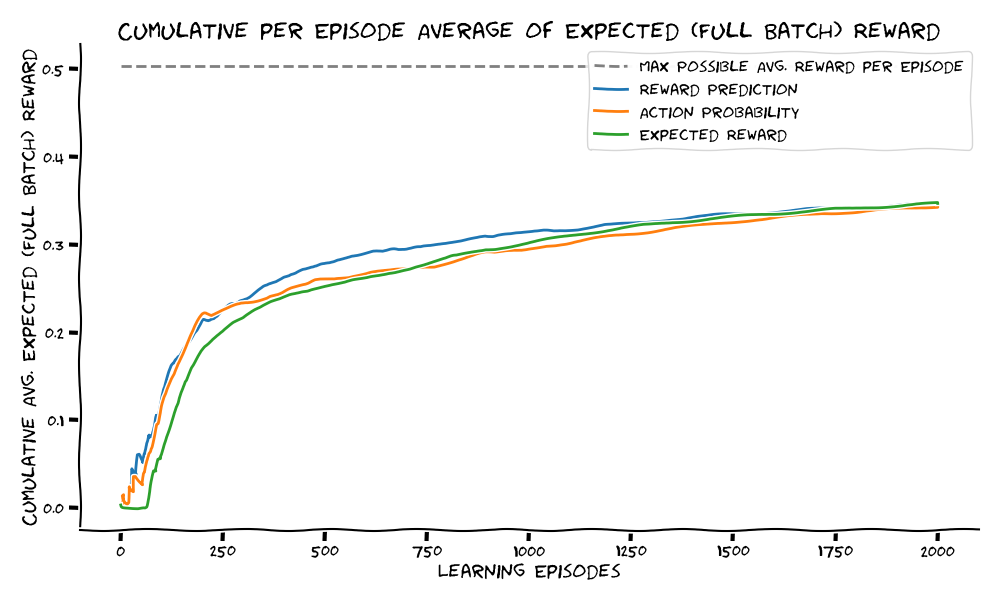

In [9]:
# @markdown **Run this cell** to see a comparison the different algorithms - reward-prediction-error, action-probability-reinforcement and expected-reward-gradient.

def action_log_prob_step(W, x, y,
                         cheat=False,
                         tau=1,
                         rng=None,
                         learning_rate=0.001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn using expected reward
    update = r_exp * (1 -  strike_prob) * x
  else: # properly episodic
    # learn only from actual recieved rewards
    # reward of zero recieved when not striking
    update = r * (1 - strike_prob) * x
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

learn_rng = np.random.default_rng(0)
num_epochs = 1
num_steps = 0
mini_batch_size = 1
cooling_rate = 0.04
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Expected Reward']
alg_funcs = [reward_prediction_step, action_prob_step, action_log_prob_step]
alg_lrs = {'Reward Prediction': 0.0001,
           'Action Probability': 0.003,
           'Expected Reward': 0.001}
actual_reward_results = {alg_name: [] for alg_name in alg_names}
exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      r = np.mean(r)
      r_exp_full = np.mean(r_exp_full)
      actual_reward_results[alg_name].append(r)
      exp_reward_results[alg_name].append(r_exp_full)
    num_steps += 1
    if num_steps > 2000:
      break
with plt.xkcd():
  fig, ax = plt.subplots(figsize=(10, 6))
  theoretical_max = np.sum(y1 == 1) / len(y1)
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval = np.array(exp_reward_results[alg_name])
    eval = np.cumsum(eval)
    eval = eval / (np.arange(len(eval)) + 1)
    ax.plot(eval, label=f'{alg_name}')
    ax.set_title(f'Cumulative per Episode Average of Expected (Full Batch) Reward')
    ax.set_xlabel('Learning Episodes')
    ax.set_ylabel('Cumulative Avg. Expected (Full Batch) Reward')
    ax.legend()
  plt.tight_layout()
  plt.show()


Comparing these three different update rules, we see that they all have relatively similar performance in terms of speed of learning. This stems from the fact that they all are leveraging knowledge of how the behaviour is produced by the network to inform the weight updates. This knowledge manifests as the term $\mathbf{x}^T$ in each of these update rules, since this determines the causal impact of changes in the weight parameters $\mathbf{W}$ on downstream probabilities of the selected action being taken or not, given the current sensory input $\mathbf{x}$. This should be contrasted with perturb-measure-step which makes no use of such knowledge. Perturb-measure-step assumes nothing about the structure of the evaluation function, both the behaviour generating aspect of parameter evaluation, and the reward response aspect of the evaluation function. A useful analogy (which we formalize later in sequence ref) is of observations as kind of currency to be spent on making better inferences about the world. Different learning algorithms can all recieve the same data-points, but how they "spend" this data on inference is what differentiates them. The same information is always present in the data, but the model archetecture and the learning algorithm determine how efficiently that information in that data is used (or not) to improve some objective. Loosely speaking, within this spending data analogy, perturb-measure-step is spending a lot of its data on inference about how the paramaters generate reward, through behaviour selection. In contrast these other update rules, take the structure of the behaviour generating function as a given, which allows them to spend all of their data on learning the association between sensory inputs and rewarding behaviour, i.e. directly improving behaviour, without "wasting" any data on implicit inference about how behaviour is generated, (as this knowledge is already embedded in the update rule). This is very abstract.

To see a concrete example of this suppose that on a particular episode $x_0$ has a value of zero. Because this $x_0$ input will have had no causal impact on the action selected in that episode none of the gradient aligned update rules will make an update to $w_0$. In contrast, perturb-measure-step may well update $w_0$, so long as the perturbed evaluation is different from the baseline evaluation. This is because, based on a single learning episode, perturb-measure-step can only make a rough guess based on correlations as to the causal impact of any one parameter on the outcome, as it does not know anything about how the parameters $\mathbf{W}$ interact with the inputs $\mathbf{x}$ to generate behaviour and resultant reward.

In [10]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.4.3 Learning To Do More Than One Thing

So far we have just focused on the case where the organism has to choose between doing something, in our cartoon example striking at prey, or refraining from doing that. There is only one thing to do, and it is either done or not done. Now we want to look at a more general kind of problem where there are many possible actions to choose from. We envision a cartoon scenario much like the first one, but now instead of either striking or not striking, we imagine that there are 10 disctinct prey types, each requiring a different capture technique. If the predator selects the correct capture technique for the particular prey type encountered, they are successful and get a reward of one, but if they select the wrong capture technique they recieve a reward of zero. (How these specific techniques are learned, and what it would even mean to learn specific stereotyped action patterns from a sensory motor perspective, we leave aside for now, and focus solely on the problem of the predator learning to associate the correct discrete capture technique with the correct prey type based on sensory inputs.)

To get a sense of this discrimination problem run the cell below and try it yourself.

In [11]:
# @markdown **Run this cell** to try out this new 10-fold discrimination task. Click the buttons to try different prey-capture techniques.

class InteractiveMNISTPredator_Multi():
  def __init__(self,
               features=Xs,
               labels=y,
               extra_labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    #sample_order = np.arange(self.features.shape[0])
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    self.extra_labels = extra_labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.current_image = None
    self.previous_image = None
    self.score = 0
    self.best_possible_score = 0
    self.successful_captures = 0
    self.failed_captures = 0
    # Initialize widgets
    # Define button labels as techniques
    capture_techniques = ["Lure", "Chase", "Stalk", "Snare", "Pounce", "Strike", "Slash", "Crush", "Pin", "Bite"]
    self.technique_to_index = {technique: i for i, technique in enumerate(capture_techniques)}
    button_style = widgets.ButtonStyle(width='80px')  # Adjust the width as needed
    self.strike_buttons = [widgets.Button(description=technique, style=button_style) for technique in capture_techniques]
    # Bind event handlers
    for btn in self.strike_buttons:
      btn.on_click(self.on_class_selected)
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.prev_fig, self.prev_ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.prev_fig)
    self.show_next_image()

    # Arrange widgets in a layout
    current_buttons = widgets.VBox([self.fig.canvas,
                                    widgets.HBox(self.strike_buttons[0:3]),
                                    widgets.HBox(self.strike_buttons[3:6]),
                                    widgets.HBox(self.strike_buttons[6:10])])
    previous_feedback = widgets.VBox([self.prev_fig.canvas, self.feedback_display])
    self.ui = widgets.HBox([previous_feedback, current_buttons, self.score_display])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]

    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the first ring to 6 (white)
      image[0, 0] = 6
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    if self.current_image is not None:
      self.previous_image = self.current_image
    image = np.flipud(image)
    self.current_image = image
    # Display the image
    #print(image)
    self.fig.clf()
    self.prev_fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.prev_ax = self.prev_fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.prev_ax.set_xlim(-.5, 7.5)
    self.prev_ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.prev_ax.set_aspect('equal')
    self.ax.axis('off')
    self.prev_ax.axis('off')
    self.ax.imshow(self.current_image, cmap='gray', vmin=-6, vmax=6, origin='upper')
    if self.previous_image is not None:
      self.prev_ax.imshow(self.previous_image, cmap='gray', vmin=-6, vmax=6, origin='upper')
    self.ax.set_title('Current Sensory Input')
    self.prev_ax.set_title('Previous Sensory Input')
    self.fig.canvas.draw()
    self.prev_fig.canvas.draw()

  def on_class_selected(self, button):
    # freeze buttons while we process
    for btn in self.strike_buttons:
      btn.disabled=True
    selected_class = self.technique_to_index[button.description]
    correct_class = int(np.squeeze(self.labels[self.current_index]))
    selected_description = button.description
    correct_description = self.strike_buttons[correct_class].description
    if selected_class == correct_class:
      self.score += 1
      self.successful_captures += 1
      feedback = f"Your last choice, '{selected_description}', was correct!"
    else:
      self.score -= 1
      self.failed_captures += 1
      feedback = f"Your last choice, '{selected_description}', was incorrect. The correct technique was '{correct_description}'."
    # show feedback
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)
    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Captures: {self.successful_captures}')
      print(f'Failed Captures: {self.failed_captures}')
      print(f'Average Score Per Trial: {average_score:.2f}')
    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    for btn in self.strike_buttons:
      btn.disabled=False


scramble_multi_hard = InteractiveMNISTPredator_Multi(
    features=Xs, labels=y, feedback_type='both')
display(scramble_multi_hard.fig.canvas)
display(scramble_multi_hard.prev_fig.canvas)
clear_output()
display(scramble_multi_hard.ui)

We found the binary discrimination task with these inputs basically intractable, so for us at least this 10-fold discrimination task is even more impossible. Let's see though if we can adapt our behaviour generating network and our learning rules to this new multi-class scenario.

We model this organism's sensory-behaviour much as before with a few small, but important, differences. As before $\mathbf{x}$ is the raw sensory input (column vector) of length 64 in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level of a single photosensitive neuron.

These input neurons are then connected by synapses to **multiple** output neurons, each one corresponding to a different possible action selection. The activation level, as a vector $\mathbf{z}$, of these output neurons is computed as
$$\mathbf{z} = \mathbf{Wx}$$
Here $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the various output neurons. In this case where there are 65 inputs (we have done our usual trick of hiding the baseline activation level by augmenting $\mathbf{x}$) and 10 outputs, so $\mathbf{W}$ has shape 10 x 65. So
$$ z_i = \sum_{j=1}^{65} w_{ij} x_j$$

**Notation reminder**: $w_{ij}$ is the weight connecting the $j^{th}$ input to the $i^{th}$ output and is the element in the $i^{th}$ row and $j^{th}$ column of $\mathbf{W}$.)

To convert these activation levels, $\mathbf{z}$, into probabilities of actions, we use softmax normalization. Softmax extends the logistic sigmoid function to handle multiple classes.
Much like the logistic sigmoid turns any real number into a probability over a binary outcome (strike or no-strike), the softmax function turns any vector of real values into a vector of probabilities over different outcomes
$$\text{softmax}(\mathbf{z}) = \frac{(\exp{z_0}, \dots, \exp(z_i), \dots, \exp(z_n))}{\sum_k \exp(z_k)}$$

We use a subscript to refere to a particular element of the softmax output so that probability of choosing a particular action $i$ can be expressed as:
$$ \Pr \{\text{action }i\} = \text{softmax}_i(\mathbf{z}) = \frac{\exp(z_i)}{\sum_k \exp(z_k)} $$

When there are only two possible actions, and one action has a fixed activation of $0$, then softmax normalization is equivalent to applying the logistic sigmoid of the variable (non-zero) activation level, to determine action probabilities. (This was shown in sequence (blah).)

Like the logistic sigmoid, softmax normalization can also have its variabilility modified by a temperature hyper-parameter, $\tau$, where high temperatures cause the distribution to be closer to a uniform distribution, and low temperatures cause the highest activation value action to be chosen with near certainty.
$$ \Pr \{\text{action }i\} = \text{softmax}_i(\mathbf{z};\tau) = \frac{\exp(z_i /\tau)}{\sum_k \exp(z_k / \tau)} $$

This motivates the following modifications of our update rules to the multi-class forms

## Reward-Prediction-Error Multi-Class Episodic Update Rule

$$\Delta W_{ij} = s \cdot (r-z_i) \cdot x_j \quad \text{if action }i\text{ taken}$$
$$\Delta W_{ij} = 0 \quad \text{if some action other than }i\text{ taken}$$
Or in vector form

$$ \Delta \mathbf{W}_{i,:} = s \cdot (r-z_i) \cdot \mathbf{x}^T$$

Here, $\mathbf{W}_{i,:}$ denotes the $i^{th}$ row of $\mathbf{W}$. Using similar notation we would use $\mathbf{W}_{:,j}$ denotes the $j^{th}$ column of $\mathbf{W}$. Note that $\mathbf{x}$ is transposed so that it becomes a row vector, and it's orientation matches that of $\mathbf{W}_{i,:}$ which is a row vector of the same length as $\mathbf{x}$.

## Action-Probability-Reinforcement Mulit-Class Episodic Update Rule

$$ \Delta W_{ij} = s \cdot r \cdot \frac{\partial}{\partial z_i}\text{softmax}_k(\mathbf{z}) \cdot x_j \quad \text{where } k \text{ corresponds to the action taken}$$

or in vector form

$$ \Delta \mathbf{W} = s \cdot r \cdot \left(\nabla_{\mathbf{z}} \text{softmax}_k(\mathbf{z})\right) \mathbf{x}^T \quad \text{where } k \text{ corresponds to the action taken}$$

In the vector formulation $\mathbf{x}^T$ is a row vector of length 65, and $\frac{\partial}{\partial \mathbf{z}}\text{softmax}(z_k)$ is a col vector of length 10, so their matrix outer product gives a matrix of shape 10 by 65 (the shape of $\mathbf{W}$.) Now much like the sigmoid function which it is a generalization of $\text{softmax}$ also has a convinient derivative, specifically

$$
\frac{\partial}{\partial z_i}\text{softmax}(\mathbf{z})_k =
\begin{cases}
-\pi(a_k)\cdot \pi(a_i) & \text{if } i \neq k \\
\pi(a_i)\cdot (1 - \pi(a_i)) & \text{if } i = k
\end{cases}
$$
Here $\pi(a_i)$ is just another way of denoting output of the softmax normalization corresponding to the probability of selecting action $a_i$, that is $ \text{softmax} (\mathbf{z})_i$, given the vector of output activations $\mathbf{z}$, but writen to ephasize that is the probability of an action being taken given a policy. This is saying that if we increase the activation of a given action, say $z_k$, we increase the probability that that action, $a_k$ is taken at a rate of $\pi(a_k)\cdot (1 - \pi(a_k))$ while simultaneously decreasing the probability (hence the negative sign) with which other actions $a_i$, $i\neq k$, are taken at a rate of $-\pi(a_k)\cdot \pi(a_i)$. Substituting this into our update rule we have

$$
\Delta W_{ij} \begin{cases}
- s \cdot r \cdot \pi(a_k)\cdot \pi(a_i) \cdot x_j & \text{if } i \neq k \\
s \cdot r \cdot \pi(a_i)\cdot (1 - \pi(a_i)) \cdot x_j & \text{if } i = k
\end{cases}
\quad \text{where } k \text{ corresponds to the action taken}$$

What this is saying is that if an action is rewarding, the weights will shift to make selection of that action given those inputs more likely given these (or similar) sensory inputs, and if an action is not rewarding the reverse is true, the weights will shift to make alternative actions more likely to be selected in given these (or similar) sensory inputs.

One important way in which this action-probability-reinforcement differs from the reward-prediction-error update is that every weight in the network is potentially updated after a given episode, in contrast to only the weights making a prediction about the reward associated with the action sampled.

## Expected-Reward-Gradient Multi-Class Episodic Update Rule

In our previous analysis we saw that the expected-reward-gradient update is equivalent to the action-log-probability-reinforcement update so extending to this insight our multi-class scenario we have

$$ \Delta W_{ij} = s \cdot r \cdot \frac{\partial}{\partial z_i}\log(\text{softmax}(z_k)) \cdot x_j \quad \text{where } k \text{ corresponds to the action taken}$$

Now $\log(\text{softmax})$ also hase a very convenient derivative.
$$
\frac{\partial}{\partial z_i}\log(\text{softmax}(z_k)) =
\begin{cases}
- \pi(a_i) & \text{if } i \neq k \\
(1 - \pi(a_i)) & \text{if } i = k
\end{cases}
$$

So putting this into our update rule we have

$$
\Delta W_{ij} \begin{cases}
- s \cdot r \cdot \pi(a_i) \cdot x_j & \text{if } i \neq k \\
s \cdot r \cdot (1 - \pi(a_i)) \cdot x_j & \text{if } i = k
\end{cases}
\quad \text{where } k \text{ corresponds to the action taken}$$

This has basically the same affect as action-probability-reinforcement, but with different scaling terms. The primary differnce between the two is that action-probability reinforcement scales down parameter changes both when actions have a very high, and when they have a very low probability, in contrast, action-log-probability-reinforcement only scales down parameter changes in proportion to the probability of not taking the selected action. The practical effect of this difference in scaling is that action-probability-reinforcement discounts updates driven by actions that were unlikely to be selected relative to action-log-probability-reinforcement.

Now that we know what our multi-class update rules are, we can implement and compare them. Before we do that though, we need to update our parameter evaluation function to this new multi-class setting

In [12]:
def np_softmax(x, tau=1):
  # high tau more exploration, low tau very little exploration
  x_scaled = x / tau
  # Shift x by subtracting the max value to prevent overflow in exp
  x_shifted = x_scaled - np.max(x_scaled, axis=0, keepdims=True)
  exps = np.exp(x_shifted)
  # Normalize the exponentials while maintaining batch structure
  softmax_output = exps / np.sum(exps, axis=0, keepdims=True)
  return softmax_output

def eval_params_multi(W, x, y, tau=1, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  z = np.dot(W, x)  # num_action x batch
  action_probs = np_softmax(z, tau)  # num_action x batch
  cumulative_probs = np.cumsum(action_probs, axis=0)
  random_samples = rng.random(size=cumulative_probs.shape[1])
  sampled_actions = (cumulative_probs > random_samples).argmax(axis=0)
  # calculate which actions were correct and compute reward
  correct = sampled_actions == y
  r = np.zeros_like(y)
  r[correct] = 1
  r[~correct] = -1  # sampled reward
  # Create an outcomes matrix and calculate expected reward
  outcomes_matrix = -np.ones_like(action_probs)
  # Set reward to +1 at the position of the correct action for each sample
  outcomes_matrix[y, np.arange(y.size)] = 1
  r_exp = np.sum(action_probs * outcomes_matrix, axis=0)  # expected reward
  return z, action_probs, sampled_actions, r, outcomes_matrix, r_exp

Now that we have our evaluation function we can adapt our update rules to the new multi-class problem. Interestingly perturb-measure-step doesn't need any adaption at all, because it is agnostic to the underlying mechanism of behaviour generation, the only modification it needs is to make use of this new evaluation function, and optimize over the appropriate number of parameters.

In the coding exercise below implement these multi-class adaptions of reward-prediction-error, action-probability-reinforcement, and action-log-probability-reinforcement.




In [13]:
################################################################################
# TODO for students: Replace ... in the lines below with one of the following
# options, each option get's used exactly once
# a1) r - z[a, np.arange(len(a))]
# a2) errors @ x.T
# b1) r[0,b] * pi[i,b] * (1 - pi[i,b]) * x[j,b]
# b2) -r[0,b] * pi_a[b] * pi[i,b] * x[j,b]
# c1) r[0,b] * (1 - pi[i,b]) * x[j,b]
# c2) -r[0,b] * pi[i,b] * x[j,b]
# This will implement different multi-class update rules driven by:
# reward-prediction-error, action-probability-reinforcement,
# and action-log-probability-reinforcement
raise NotImplementedError("Exercise: Implement different multi-class update rules to compare")
################################################################################

def np_softmax(x, tau=1):
  # high tau more exploration, low tau very little exploration
  x_scaled = x / tau
  # Shift x by subtracting the max value to prevent overflow in exp
  x_shifted = x_scaled - np.max(x_scaled, axis=0, keepdims=True)
  exps = np.exp(x_shifted)
  # Normalize the exponentials while maintaining batch structure
  softmax_output = exps / np.sum(exps, axis=0, keepdims=True)
  return softmax_output

def eval_params_multi(W, x, y, tau=1, rng=None):
  # W shape is num_action x input
  # x shape is input x batch
  # y shape is 1 x batch
  if rng is None:
    rng = np.random.default_rng()
  z = np.dot(W, x)  # num_action x batch
  pi = np_softmax(z, tau)  # num_action x batch
  cumulative_probs = np.cumsum(pi, axis=0)
  random_samples = rng.random(size=cumulative_probs.shape[1])
  #sampled actions
  a = (cumulative_probs > random_samples).argmax(axis=0)
  # calculate which actions were correct and compute reward
  correct = a == y
  r = np.zeros_like(y)
  r[correct] = 1
  r[~correct] = -1  # sampled reward
  # Create an outcomes matrix to calculate expected reward
  outcomes_matrix = -np.ones_like(pi)
  # Set reward to +1 at the position of the correct action for each sample
  outcomes_matrix[np.squeeze(y), np.arange(z.shape[1])] = 1
  r_exp = np.sum(pi * outcomes_matrix, axis=0)  # expected reward
  return z, pi, a, r, outcomes_matrix, r_exp

def reward_prediction_multi(W, x, y,
                            tau=1.0,
                            rng=None,
                            learning_rate=0.0001):
  z, pi, a, r, outcomes_matrix, r_exp = eval_params_multi(W, x, y, tau, rng)
  # learn only from actual received rewards
  errors = np.zeros_like(z)
  actual_errors = ...
  errors[a, np.arange(len(a))] = actual_errors
  # implicit sum over batch here in this matrix multiplication
  update = ...  # errors is num_actions x batch, x.T is batch x num_features, update is num_actions x num_features
  update /= x.shape[1]  # Divide by the number of samples in batch to make the sum an average
  W_new = W + learning_rate * update  # Apply learning rate to update step
  return W_new, r, r_exp

def action_prob_multi(W, x, y,
                      tau=1,
                      rng=None,
                      learning_rate=0.001,
                      test=False):
  z, pi, a, r, outcomes_matrix, r_exp = eval_params_multi(W, x, y, tau, rng)
  num_actions, batch_size = pi.shape
  num_features = x.shape[0]
  pi_a = pi[a, np.arange(len(a))]  # [batch_size]
  broadcast_pi_a = np.broadcast_to(pi_a.reshape(1,batch_size), (num_actions, batch_size))
  # Compute updates for case when row (i) of W does not correspond to the sampled action
  delta_W = np.zeros((num_actions, num_features, batch_size))
  delta_W -= r[np.newaxis,:,:] * broadcast_pi_a[:,np.newaxis,:] * pi[:,np.newaxis,:] * x[np.newaxis,:,:]  # Shape [num_actions, num_features, batch_size]
  # now compute updates for case when row (i) of W does correspond to the sampled action
  mask = np.arange(num_actions)[:, None] == a[None, :]  # [num_actions, batch_size]
  mask = np.broadcast_to(mask[:,np.newaxis,:], delta_W.shape) # [num_actions, num_features, batch_size]
  positive_update = r[np.newaxis,:,:] * (pi * (1 - pi))[:,np.newaxis,:] * x[np.newaxis,:,:]  # [num_features, num_actions, batch_size]
  # Use positive update where appropriate
  delta_W[mask] = positive_update[mask]
  # average over the elements of the mini-batch
  delta_W = np.mean(delta_W, axis=2)
  W_new = W + learning_rate * delta_W
  if test:
    # as a sanity check on all the clever broadcasting and array operations
    # check against bog simple for loop implementation
    delta_W_test = np.zeros_like(delta_W)
    for b in range(batch_size):
      for i in range(num_actions):
        for j in range(num_features):
          if i == a[b]:
            delta_W_test[i,j,b] = ...
          else:
            delta_W_test[i,j,b] = ...
    assert np.allclose(delta_W, delta_W_test)
  return W_new, r, r_exp

def action_log_prob_multi(W, x, y,
                          tau=1,
                          rng=None,
                          learning_rate=0.001,
                          test=False):
  z, pi, a, r, outcomes_matrix, r_exp = eval_params_multi(W, x, y, tau, rng)
  num_actions, batch_size = pi.shape
  num_features = x.shape[0]
  # Compute updates for case when row (i) of W does not correspond to the sampled action
  a_1hot = np.zeros_like(pi)  # [num_actions, batch_size]
  a_1hot[a, np.arange(batch_size)] = 1
  pi_term = a_1hot - pi
  delta_W = r[np.newaxis,:,:] * pi_term[:,np.newaxis,:] * x[np.newaxis,:,:]  # Shape [num_actions, num_features, batch_size]
  # average over the elements of the mini-batch
  delta_W = np.mean(delta_W, axis=2)
  W_new = W + learning_rate * delta_W
  if test:
    # as a sanity check on all the clever broadcasting and array operations
    # check against bog simple for loop implementation
    delta_W_test = np.zeros_like(delta_W)
    for b in range(batch_size):
      for i in range(num_actions):
        for j in range(num_features):
          if i == a[b]:
            delta_W_test[i,j,b] = ...
          else:
            delta_W_test[i,j,b] = ...
    assert np.allclose(delta_W, delta_W_test)
  return W_new, r, r_exp

############### Exercise Complete ###############
##### Simulation and Plotting Logic Follows #####

def always_cheat_perturb_measure_multi(W, x, y,
                                      perturbation_scale=0.0001,
                                      tau=1,
                                      rng=None,
                                      learning_rate=0.001):
  if rng is None:
    rng = np.random.default_rng()
  z, pi, a, r, outcomes_matrix, r_exp = eval_params_multi(W, x, y, tau, rng)
  raw_test_perturb = learn_rng.standard_normal(size=(W.shape))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  perturbed_W = W + test_perturbation
  _, _, _, r_perturb, _, r_exp_perturb = eval_params_multi(perturbed_W, x, y, tau, rng)
  directional_grad_est = (np.mean(r_exp_perturb - r_exp)) / perturbation_scale
  update = learning_rate * directional_grad_est * unit_test_perturb
  W_new = W + update
  return W_new, r, r_exp

# simulation
learn_rng = np.random.default_rng(0)
num_epochs = 10000
num_steps = 0
mini_batch_size = 281
cooling_rate = 0.01
W_init = np.zeros((10,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Action Log Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_multi, action_prob_multi, action_log_prob_multi, always_cheat_perturb_measure_multi]
alg_lrs = {'Reward Prediction': 0.0001,
           'Action Probability': 0.008,
           'Action Log Probability': 0.004,
           'Perturb Measure': 0.01}
reward_results = {alg_name: [] for alg_name in alg_names}
exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      # perturb-measure-step uses r_exp everything else just uses r
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params_multi(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      reward_results[alg_name].append(np.mean(r))
      exp_reward_results[alg_name].append(np.mean(r_exp_full))
    num_steps += 1
  if num_steps > 2000:
    break

fig, ax1 = plt.subplots()
theoretical_max = 1.0
# Colors for algorithms
colors = {'Reward Prediction': 'blue', 'Action Probability': 'green',
          'Action Log Probability': 'orange', 'Perturb Measure': 'red'}

# First subplot for expected rewards
ax1.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
for alg_name in alg_names:
  eval = np.array(exp_reward_results[alg_name])
  eval = np.cumsum(eval)
  eval = eval / (np.arange(len(eval)) + 1)
  ax1.plot(eval, linestyle='-', color=colors[alg_name], label=f'{alg_name}')
  ax1.set_title('Cumulative per Episode Average of\nExpected (Full Batch) Reward')
  ax1.set_ylabel('Cumulative Avg. Expected Reward')
  ax1.legend()
plt.show()

NotImplementedError: Exercise: Implement different multi-class update rules to compare

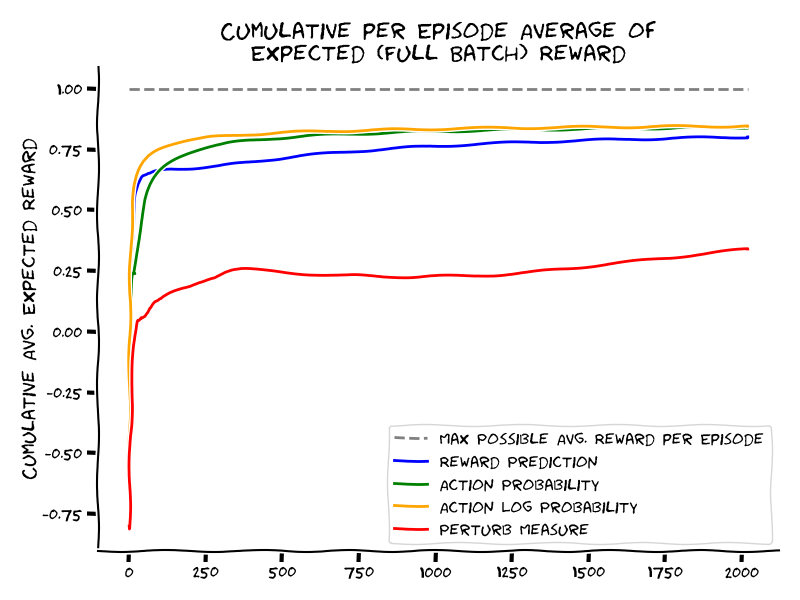

/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.manager.handle_json(content)


In [14]:
# to_remove solution

def np_softmax(x, tau=1):
  # high tau more exploration, low tau very little exploration
  x_scaled = x / tau
  # Shift x by subtracting the max value to prevent overflow in exp
  x_shifted = x_scaled - np.max(x_scaled, axis=0, keepdims=True)
  exps = np.exp(x_shifted)
  # Normalize the exponentials while maintaining batch structure
  softmax_output = exps / np.sum(exps, axis=0, keepdims=True)
  return softmax_output

def eval_params_multi(W, x, y, tau=1, rng=None):
  # W shape is num_action x input
  # x shape is input x batch
  # y shape is 1 x batch
  if rng is None:
    rng = np.random.default_rng()
  z = np.dot(W, x)  # num_action x batch
  pi = np_softmax(z, tau)  # num_action x batch
  cumulative_probs = np.cumsum(pi, axis=0)
  random_samples = rng.random(size=cumulative_probs.shape[1])
  #sampled actions
  a = (cumulative_probs > random_samples).argmax(axis=0)
  # calculate which actions were correct and compute reward
  correct = a == y
  r = np.zeros_like(y)
  r[correct] = 1
  r[~correct] = -1  # sampled reward
  # Create an outcomes matrix to calculate expected reward
  outcomes_matrix = -np.ones_like(pi)
  # Set reward to +1 at the position of the correct action for each sample
  outcomes_matrix[np.squeeze(y), np.arange(z.shape[1])] = 1
  r_exp = np.sum(pi * outcomes_matrix, axis=0)  # expected reward
  return z, pi, a, r, outcomes_matrix, r_exp

def reward_prediction_multi(W, x, y,
                            tau=1.0,
                            rng=None,
                            learning_rate=0.0001):
  z, pi, a, r, outcomes_matrix, r_exp = eval_params_multi(W, x, y, tau, rng)
  # learn only from actual received rewards
  errors = np.zeros_like(z)
  actual_errors = r - z[a, np.arange(len(a))]
  errors[a, np.arange(len(a))] = actual_errors
  # implicit sum over batch here in this matrix multiplication
  update = errors @ x.T  # errors is num_actions x batch, x.T is batch x num_features, update is num_actions x num_features
  update /= x.shape[1]  # Divide by the number of samples in batch to make the sum an average
  W_new = W + learning_rate * update  # Apply learning rate to update step
  return W_new, r, r_exp

def action_prob_multi(W, x, y,
                      tau=1,
                      rng=None,
                      learning_rate=0.001,
                      test=False):
  z, pi, a, r, outcomes_matrix, r_exp = eval_params_multi(W, x, y, tau, rng)
  num_actions, batch_size = pi.shape
  num_features = x.shape[0]
  pi_a = pi[a, np.arange(len(a))]  # [batch_size]
  broadcast_pi_a = np.broadcast_to(pi_a.reshape(1,batch_size), (num_actions, batch_size))
  # Compute updates for case when row (i) of W does not correspond to the sampled action
  delta_W = np.zeros((num_actions, num_features, batch_size))
  delta_W -= r[np.newaxis,:,:] * broadcast_pi_a[:,np.newaxis,:] * pi[:,np.newaxis,:] * x[np.newaxis,:,:]  # Shape [num_actions, num_features, batch_size]
  # now compute updates for case when row (i) of W does correspond to the sampled action
  mask = np.arange(num_actions)[:, None] == a[None, :]  # [num_actions, batch_size]
  mask = np.broadcast_to(mask[:,np.newaxis,:], delta_W.shape) # [num_actions, num_features, batch_size]
  positive_update = r[np.newaxis,:,:] * (pi * (1 - pi))[:,np.newaxis,:] * x[np.newaxis,:,:]  # [num_features, num_actions, batch_size]
  # Use positive update where appropriate
  delta_W[mask] = positive_update[mask]
  # average over the elements of the mini-batch
  delta_W = np.mean(delta_W, axis=2)
  W_new = W + learning_rate * delta_W
  if test:
    # as a sanity check on all the clever broadcasting and array operations
    # check against bog simple for loop implementation
    delta_W_test = np.zeros_like(delta_W)
    for b in range(batch_size):
      for i in range(num_actions):
        for j in range(num_features):
          if i == a[b]:
            delta_W_test[i,j,b] = r[0,b] * pi[i,b] * (1 - pi[i,b]) * x[j,b]
          else:
            delta_W_test[i,j,b] = -r[0,b] * pi_a[b] * pi[i,b] * x[j,b]
    assert np.allclose(delta_W, delta_W_test)
  return W_new, r, r_exp

def action_log_prob_multi(W, x, y,
                          tau=1,
                          rng=None,
                          learning_rate=0.001,
                          test=False):
  z, pi, a, r, outcomes_matrix, r_exp = eval_params_multi(W, x, y, tau, rng)
  num_actions, batch_size = pi.shape
  num_features = x.shape[0]
  # Compute updates for case when row (i) of W does not correspond to the sampled action
  a_1hot = np.zeros_like(pi)  # [num_actions, batch_size]
  a_1hot[a, np.arange(batch_size)] = 1
  pi_term = a_1hot - pi
  delta_W = r[np.newaxis,:,:] * pi_term[:,np.newaxis,:] * x[np.newaxis,:,:]  # Shape [num_actions, num_features, batch_size]
  # average over the elements of the mini-batch
  delta_W = np.mean(delta_W, axis=2)
  W_new = W + learning_rate * delta_W
  if test:
    # as a sanity check on all the clever broadcasting and array operations
    # check against bog simple for loop implementation
    delta_W_test = np.zeros_like(delta_W)
    for b in range(batch_size):
      for i in range(num_actions):
        for j in range(num_features):
          if i == a[b]:
            delta_W_test[i,j,b] = r[0,b] * (1 - pi[i,b]) * x[j,b]
          else:
            delta_W_test[i,j,b] = -r[0,b] * pi[i,b] * x[j,b]
    assert np.allclose(delta_W, delta_W_test)
  return W_new, r, r_exp

############### Exercise Complete ###############
##### Simulation and Plotting Logic Follows #####

def always_cheat_perturb_measure_multi(W, x, y,
                                      perturbation_scale=0.0001,
                                      tau=1,
                                      rng=None,
                                      learning_rate=0.001):
  if rng is None:
    rng = np.random.default_rng()
  z, pi, a, r, outcomes_matrix, r_exp = eval_params_multi(W, x, y, tau, rng)
  raw_test_perturb = learn_rng.standard_normal(size=(W.shape))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  perturbed_W = W + test_perturbation
  _, _, _, r_perturb, _, r_exp_perturb = eval_params_multi(perturbed_W, x, y, tau, rng)
  directional_grad_est = (np.mean(r_exp_perturb - r_exp)) / perturbation_scale
  update = learning_rate * directional_grad_est * unit_test_perturb
  W_new = W + update
  return W_new, r, r_exp

# simulation
learn_rng = np.random.default_rng(0)
num_epochs = 10000
num_steps = 0
mini_batch_size = 281
cooling_rate = 0.01
W_init = np.zeros((10,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Action Log Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_multi, action_prob_multi, action_log_prob_multi, always_cheat_perturb_measure_multi]
alg_lrs = {'Reward Prediction': 0.0001,
           'Action Probability': 0.008,
           'Action Log Probability': 0.004,
           'Perturb Measure': 0.01}
reward_results = {alg_name: [] for alg_name in alg_names}
exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      # perturb-measure-step uses r_exp everything else just uses r
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params_multi(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      reward_results[alg_name].append(np.mean(r))
      exp_reward_results[alg_name].append(np.mean(r_exp_full))
    num_steps += 1
  if num_steps > 2000:
    break

with plt.xkcd():
  fig, ax1 = plt.subplots()
  theoretical_max = 1.0
  # Colors for algorithms
  colors = {'Reward Prediction': 'blue', 'Action Probability': 'green',
            'Action Log Probability': 'orange', 'Perturb Measure': 'red'}

  # First subplot for expected rewards
  ax1.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval = np.array(exp_reward_results[alg_name])
    eval = np.cumsum(eval)
    eval = eval / (np.arange(len(eval)) + 1)
    ax1.plot(eval, linestyle='-', color=colors[alg_name], label=f'{alg_name}')

    ax1.set_title('Cumulative per Episode Average of\nExpected (Full Batch) Reward')
    ax1.set_ylabel('Cumulative Avg. Expected Reward')
    ax1.legend()
  plt.show()

In this harder problem each of the gradient aligned update rules (reward-prediction-error, action-probability-reinforcement, action-log-probability-reinforcement) all are able to achieve an average reward per episode of roughly 0.75, which means they choose the "correct" action roughly 88% of the time. Eventually perturb-measure-step will also be able to achieve this level of performance, but learning is slow with perturb-measure-step. In the simulation above perturb-measure-step was allowed to "cheat" in the sense that it used the expected reward (not sampled reward) to evaluate perturbed versus base parameters. Also in the simulation above, to further help perturb-meausure-step each 'epsiode' consisted of mini-batch of 281 experiences, that is $(\mathbf{x}, y)$ pairs. In contrast the other learning rules adapted using sampled actions and the resulting rewards.

This further highlights some of differences between perturb-measure-step and these other gradient aligned methods noted earlier. Each of these gradient oriented update rules needed to be recomputed for this new multi-class output. In contrast the perturb-measure-step update rule needed basically no adaption at all. A new evaluation function could simply be swapped into perturb-measure-step. This difference in ease of implementation in code is important, as it stems from the crucial difference between these different classes of update methods. Perturb-measure-step is what is called a zeroeth-order method, in that it requires absolutly zero information about the underlying structure of the evaluation function being optimized, only the ability to use the evaluation function to evaluate parameters. Optimization processes like this are sometime called "black box", since they only see inputs to an evaluation function (the parameter weights $\mathbf{W}$ in our case), and some (potentially noisy) evaluation of those parameters in the form of a reward. In contrast reward-prediction-error, action-probability-reinforcement, and action-log-probability-reinforcement all belong a class of optimization mehtods known as first-order methods. First-order refers to the use of knowledge of the **structure** of the parameter evaluation function, and in particular knoweldge in the form of derivatives (of the first-order) of various parts of the evaluation function with respect to the parameters. Second order methods also exist which not only take into account the first derivatives of the evaluation function with respect to the parameters, i.e. local linear rates of change, but also second derivatives, i.e. local curvature, to inform parameter updates. We will learn more about second order methods in sequence (blah).

So perturb-measure-step is robust in the sense that it can be readily applied to any optimization problem without any condideration of the particular structure of the problem, but this generality comes at the cost of compartively slow learning. In contrast, first order methods can find good solutions much more quickly, but implementation of these methods is more problem specific, as at least some of the structure of the evaluation function is used to inform the update rule. In the rules we looked at the gradient of the activations with respect to the weights, $\nabla_{\mathbf{W}}\mathbf{z}$, was critical to improving behaviour, either through improving a reward prediction, or directly reinforcing the probabilities (log-probailities) of actions taken with reward recieved.

In [15]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

## Conclusion
We have now learned about an important way of speeding up learning. That is, by making parameter updates that are (mostly) aligned with the gradient of the function (in this case expected reward) that we are trying to improve through learning. Doing this, however, requires using update rules that somehow utilize implicit knowledge of the structure of the function being optimized. Our gradient aligned methods made use of implicit knowledge about how the sensory inputs interacted with the parameter weights to cause action selection. The "cheating" variants of all of our update rules made use of knowledge of how actions combined with the true state of the environment to compute the "true" expected reward given the action probabilities, instead of simply relying on an estimate of this expected reward based on sampled actions and resultant rewards. How these both of these kinds of "knowledge about structure", that is "knowledge of self in the form of how parameters generate actions from sensory inputs" and "knowledge of the world in the form of how actions generate rewards" can be used to inform local synaptic plasticity update rules in the brain is an important issue that leave aside for the moment. We do emphasize however, that biological plausibility needs to be considered both from the micro perspective of electro-physiological mechanisms and also from the macro perspective of behavioural learning efficacy. Animals acquire adaptive behaviours rapidly, often after only a few dozen learning episodes for simple associations. There are likely many complimentary process at play allowing for this rapid learning. The point though is that any plasticity rule which does not support this kind of rapid learning, is not plausible at the macro level of explaining learning behaviour, and so must be discounted no matter how empirically well supported the underlying electro-physiological mechanisms are at the micro level.

In the next sequence we shift our focus from learning speed, to "final" performance. Here we kept our model archetecture fixed and to compare the relative rates of improvement driven by different update rules. In the next sequence we will keep our basic update rule fixed and focus the highest level of performance possible given different models a sensory-behaviour system, in particular looking at what more complex (more parameter) models are able to achieve.

_____
# Bio Box: Biological Plausibility Constrained Above and Below

We need to think of biological plausibility of learning mechanisms as constrained on two ends.

1. From below, by the plausibility of the electro-physiological mechanisms of neural plasticity,
2. From above, by the plausibility of the efficacy of the learning rule implemented by those mechanisms.

From the perspective of the constraints of electro-physiological mechansims alone an algorithm like perturb-measure-step is very appealing. Perturb-measure-step implements a kind of optimization with no knowledge of the structure of the network that generates the behaviour or the environmental dynamics that then provide reward contingent on behaviour. This makes it easy to reconcile such a learning rule with the observed facts of synaptic plasticity, e.g. Hebbian learning modulated by global reward signals . However, this comes at the cost taking relatively many learning trials to discover good parameters. Thus perturb-measure-step runs into an efficacu constraint when considering optimization of large and complex neural ciruits. Is is simply too slow to account for the synaptic plasticty underlying the **rapid** aquisition of adaptive behaviours observed (near unviserally) in animals. Thus while algorithms roughly like perturb-measure-step are likely implemented and useful for configuring many small and simple neural circuits, they cannot account for all of synaptic plasticity, and in particular the adaptive plasticity in large networks.

From the perspective of plausible efficacy, update rules which do make use of knowledge of structure of the network that generates behaviour and/or the environmental dynamics that then provide reward, are more appealing, because they are effective and quick, even in an online, episodic context where learning is driven exclusively by actual experiences (not hypothetical distributions of experiences and expectated values of reward.). However, from the perpsective electro-physiological mechanisms, the question of how knowledge of the structure of the behaviour generating network and/or the dynamics of the environment is implemented on the level of electro-physiological mechanisms is a challenge. However, this is a challenge that needs to be embraced: as networks become large, perturb-measure-step and related methods are non-starters in terms of candidate learning mechanisms because they are simply not **effective** enough.

A physiologically simple mechanism that predicts learning on the time course of millions of learning episodes, when behaviourally we see learning over a time course of dozens of episodes, is not biologically plausible. Practical efficacy and eltro-physiological mechansims are **both** necissary constraints on any update rule that purports to describe the dynamics of synaptic plasticit used by the brain to rapidly aquire adaptive behaviours!

# Algo Box: Zeroeth Order Methods
We have primarily used propose-accept-reject and perturb-measure-step as our work-horse zeroeth order methods in examples because of their conceptual simplicity. Zeroeth order methods are important and useful tools in that they make no assumptions, and require no knowledge of the underlying strcuture of the optimization problem. They build up this knowledge purely by inference/experience, evaluating the function to be optimized many times. This situation of having no knowledge, or at least no helpful knowledge, does indeed occur in many practical settings, and in such situations zeroeth order methods are the only option available.

The best of such methods extend build on the core ideas of propose-accept-reject and perturb-measure-step, by keeping track of a population of sample points, and then using the relative evaluations of these samples points to inform the selection of new sample points. Such methods make inferences (either implicitly through geometry e.g. in the Nedler-Mead algorithm or explicitly as in the case of Covariance Matrix Adaptation - Evolutionary Strategy, CMA-ES), about both the direction greatest improvement (gradient) which informs which general direction in parameter space new test points should be sampled from relative to the current population of test points, and the curvature of the evaluation fucntion in the neighbourhood of the current test population, which informs how dispersed from the current population of test points new test points should be. High curvature in a given direction means small steps need to be taken in that direction to avoid overshooting as the gradient in that direction is rapidly changing, whereas low curvature in a given direction means that large steps can be taken with lower risk of overshooting as the gradient is relatively stable in that direction.

Covariance Matrix Adaption - Evolutionay Strategy is one such state of the art zeoreth order methods, and as the name implies, takes some of its inspiration from the evolutionary processes of natural selection.

In [16]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")